# Sequence homology searching 

In this chapter we'll talk about using pairwise alignment to search databases of biological sequences with the goal of identifying sequence homology. We previously defined homology between a pair of sequences to mean that those sequences are derived from a common ancestral sequence. Homology searching is an essential part of making inferences about where a biological sequence came from, and/or what it does. In most cases, if you have an unannotated biological sequence, such as the following protein sequence, it's very hard (really, impossible) to know what it is without more information.

What a researcher will often do is search this sequence, their **query**, against some **reference database** of annotated sequences to learn what function the sequence performs (if the reference database contains functional annotation of sequences) and/or what organisms are likely to encode this sequence in their genome (if the reference database contains taxonomic annotation of sequences).

````{admonition} Exercise
Whose genome is the following sequence encoded in? What is its function? Take a minute now to answer these questions using the [Protein BLAST homology search tool on the NCBI website](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastp&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome).

```
>mystery-sequence1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT
LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK
CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN
CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD
YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC
NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN
FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP
GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY
ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI
SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE
VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC
LGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAM
QMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN
TLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA
SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPA
ICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDP
LQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDL
QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD
SEPVLKGVKLHYT
```

````

In the context of database searching, a query sequence and a reference sequence that we hypothesize to be homologous can be identical to one another, or they can differ as a result of mutation events. When sequences differ, we're often then interested in how much they differ, or their pairwise similarity, which can help us identify the most closely related of several homologs in the reference database. There is an important distinction in the terms **homology** and **similarity**: homology is a discrete variable, and similarity is a continuous variable. A pair of biological sequences either *are* or *are not* derived from a common ancestor, but they can be more or less similar to each other. Saying that two sequences are 80% homologous doesn't make sense. What people generally mean when they say this is that two sequences are 80% similar, and as a result they are hypothesizing homology between the sequences.

**Similarity** between a pair of sequences can be computed in a few different ways. In this text, unless otherwise noted, we'll compute similar as: $Similarity = 1 - Hamming\ distance$. Recall that Hamming distance is the fraction of positions that differ between aligned sequences. Similarity is therefore the inverse of that: the fraction of positions that do not differ between aligned sequences.

## Defining the problem 

As mentioned above, if we want to perform a homology search we'll have one or more **query sequences**, and for each we want to know which sequence(s) in a reference database it is most similar to.

Sequence homology searching can be implemented in a few ways. In this chapter, we'll use the local alignment function that we worked with in the Pairwise Alignment chapter, ``local_pairwise_align_ssw``, run it many times to search one query sequence against many reference sequences, and investigate the highest scoring alignment(s) to identify the best database match. Remember that you can always get help with a function by passing it as an argument to ``help``:

In [1]:
from skbio.alignment import local_pairwise_align_ssw
help(local_pairwise_align_ssw)

Help on function local_pairwise_align_ssw in module skbio.alignment._pairwise:

local_pairwise_align_ssw(sequence1, sequence2, **kwargs)
    Align query and target sequences with Striped Smith-Waterman.
    
    State: Experimental as of 0.4.0.
    
    Parameters
    ----------
    sequence1 : DNA, RNA, or Protein
        The first unaligned sequence
    sequence2 : DNA, RNA, or Protein
        The second unaligned sequence
    
    Returns
    -------
    tuple
        ``TabularMSA`` object containing the aligned sequences, alignment score
        (float), and start/end positions of each input sequence (iterable
        of two-item tuples). Note that start/end positions are indexes into the
        unaligned sequences.
    
    Notes
    -----
    This is a wrapper for the SSW package [1]_.
    
    For a complete list of optional keyword-arguments that can be provided,
    see ``skbio.alignment.StripedSmithWaterman``.
    
    The following kwargs will not have any effect: `suppress

When our reference database starts getting hundreds of millions of bases long (as would be the case if we were searching against 97% OTUs from the [Greengenes small-subunit ribosomal RNA (SSU rRNA) reference database](http://www.ncbi.nlm.nih.gov/pubmed/22134646)), billions of bases long (as would be the case if we were searching against [the human genome](https://genome.ucsc.edu/cgi-bin/hgGateway)) or trillions of bases long (as would be the case if we were searching against the [NCBI non-redundant nucleotide database](http://www.ncbi.nlm.nih.gov/refseq/)), runtime becomes an important consideration. For that reason, learning about *heuristic algorithms* is an essential part of learning about sequence homology searching. Heuristic algorithms apply some rules (i.e., heuristics) to approximate the correct solution to a problem in a fraction of the runtime that would be required if we wanted to be guaranteed to find the correct solution. Heuristic algorithms are very common in bioinformatics, and we'll use them in several other places in this book.

While we'll be aligning nucleotide sequences in this chapter, the same concepts apply to protein homology searching.

(load-qdr)=
## Loading annotated sequences 

````{margin}
```{note}
We're accessing Greengenes sequences here through the [QIIME default reference project](https://github.com/biocore/qiime-default-reference). The QIIME default reference project isn't actually used by recent versions of QIIME but it's a convenient resource for accessing a collection of 16S sequences from Python. This resource is handy if you need some sequences for experimental purposes, but is outdated and shouldn't be used in practice.
```
````

The first thing we'll do as we learn about sequence homology searching is load some annotated sequences. The sequences that we're going to work with are derived from the [Greengenes](http://greengenes.secondgenome.com/) database. Greengenes is a database of 16S rRNA gene sequences, a component of the archaeal and bacterial [ribosome](http://www.nature.com/scitable/definition/ribosome-194) (the molecular machine that drives translation of mRNA to proteins). This gene is of a lot of interest to biologists because it's one of about 200 genes that are encoded in the genomes of all known cellular organisms. The sequences in Greengenes are taxonomically annotated, meaning that we'll have a collection of gene sequences and the taxonomic identity of the organism whose genome the sequence is found in. If we search an unannotated 16S rRNA query sequence against this database, we can make inferences about what organism our query sequence is from.

First, let's load Greengenes into a list of ``skbio.DNA`` sequence objects, and associate the taxonomy of each sequence as sequence metadata.

In [2]:
# This cell performs some configuration for this notebook. It's hidden by
# default because it's not relevant to the content of this chapter. You'll
# occasionally notice that I hide this type of information so it's not 
# distracting.

%pylab inline

from IPython.core import page
page.page = print

Populating the interactive namespace from numpy and matplotlib


In [3]:
import qiime_default_reference as qdr
import skbio

def load_taxonomy_reference_database(verbose=True):
    # Load the taxonomic data
    reference_taxonomy = {}
    for e in open(qdr.get_reference_taxonomy()):
        seq_id, seq_tax = e.strip().split('\t')
        reference_taxonomy[seq_id] = seq_tax

    # Load the reference sequences, and associate the taxonomic annotation with
    # each as metadata
    reference_db = []
    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', constructor=skbio.DNA):
        if e.has_degenerates():
            # For the purpose of this lesson, we're going to ignore sequences that contain
            # degenerate characters (i.e., characters other than A, C, G, or T)
            continue
        seq_tax = reference_taxonomy[e.metadata['id']]
        e.metadata['taxonomy'] = seq_tax
        reference_db.append(e)

    if verbose:
        print("%s sequences were loaded from the reference database." % len(reference_db))

    return reference_taxonomy, reference_db

In [4]:
reference_taxonomy, reference_db = load_taxonomy_reference_database()

88452 sequences were loaded from the reference database.


Next, we'll just inspect a couple of the sequences we loaded. Notice how the specificity of our taxonomic annotations (i.e., how many taxonomic levels are annotated and unknown) differs for different sequences.

In [5]:
reference_db[0]

DNA
-----------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '1111883'
    'taxonomy': 'k__Bacteria; p__Gemmatimonadetes; c__Gemm-1; o__; f__;
                 g__; s__'
Stats:
    length: 1428
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 61.90%
-----------------------------------------------------------------------
0    GCTGGCGGCG TGCCTAACAC ATGTAAGTCG AACGGGACTG GGGGCAACTC CAGTTCAGTG
60   GCAGACGGGT GCGTAACACG TGAGCAACTT GTCCGACGGC GGGGGATAGC CGGCCCAACG
...
1320 GCCGCGGTGA ATACGTTCCC GGGCCTTGTA CACACCGCCC GTCACGCCAT GGAAGCCGGA
1380 GGGACCCGAA ACCGGTGGGC CAACCGCAAG GGGGCAGCCG TCTAAGGT

In [6]:
reference_db[-1]

DNA
----------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '4483258'
    'taxonomy': 'k__Archaea; p__Crenarchaeota; c__Thermoprotei;
                 o__Thermoproteales; f__Thermoproteaceae; g__; s__'
Stats:
    length: 2123
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 58.36%
----------------------------------------------------------------------
0    CTGGTTGATC CTGCCGGACC CGACCGCTAT CGGGGTGGGG CTTAGCCATG CGAGTCAAGC
60   GCCCCAGGGA CCCGCTGGGG TGCGGCGCAC GGCTCAGTAA CACGTGGCCA ACCTACCCTC
...
2040 ATAATCTCCT TATTGTCTGA TCCTTATGCA TTTTCCTTTG GCCCATCCCG TGAATACGCG
2100 CGGTGAATAC GTCCCTGCCC CTT

For the sake of runtime, we're going to work through this chapter using a random sample of sequences from this database. Here we'll use Python's [random module](https://docs.python.org/3/library/random.html) to select sequences at random.

In [7]:
import random

reference_db = random.sample(reference_db, k=5000)
print("%s sequences are present in the subsampled database." % len(reference_db))

5000 sequences are present in the subsampled database.


We'll also extract some sequences from Greengenes to use as query sequences in our database searches. This time we won't annotate them (to simulate not knowing what organisms they're from). We'll also trim these sequences so they're shorter than the full length references. This will simulate obtaining a partial gene sequence, as is most common with the current sequencing technologies (as of this writing), but will also help to make the examples run faster.

Note that some of our query sequences may also be in our subsampled reference database and some won't. This is realistic: sometimes we're working with sequences that are exact matches to known sequences, and sometimes we're working with sequences that don't match any known sequences (or at least any in the reference database that we're working with).

In [8]:
def load_taxonomy_query_sequences(start_position=100, length=200):
    queries = []
    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', constructor=skbio.DNA):
        if e.has_degenerates():
            # For the purpose of this lesson, we're going to ignore sequences that contain
            # degenerate characters (i.e., characters other than A, C, G, or T)
            continue
        e = e[start_position:start_position + length]
        queries.append(e)

    return queries

In [9]:
queries = load_taxonomy_query_sequences()
queries = random.sample(queries, k=50)

Let's inspect a couple of the query sequences that we'll work with.

In [10]:
queries[0]

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '301292'
Stats:
    length: 200
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 52.00%
---------------------------------------------------------------------
0   AGGTAACCTG CCCTTAAGCT TGGGATACCC AGAGGAAACT TTGGCTAATA CCGGATAACA
60  ACAGAGAAGG CATCTTCTTT GCTTGAAAGG CCCTTCACGG GGTCACTTAA GGATGGACCT
120 GCGGCGCATT AGCTAGTTGG TGAGATAACA GCCCACCAAG GCGAGGATGC GTAGCCGAAC
180 TGAGAGGTTG ATCGGCCACA

In [11]:
queries[-1]

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': '4405106'
Stats:
    length: 200
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 53.50%
---------------------------------------------------------------------
0   GTGAATAACC TGCCTCACAC AGGGGGGTAA CAGTTAGAAA TGACTGCTAA TACCGCATAA
60  GCGCACGGTA CCGCATGGTA CAGTGTGAAA AACTCCGGTG GTGTGAGATG GATCCGCGTC
120 TGATTAGGTA GTTGGTGAGG TAACGGCCCA CCAAGCCGAC GATCAGTAAC CGACCTGAGA
180 GGGTGATCGG CCACATTGGG

## Defining the problem 

The problem that we are going to address here is as follows. We now have a query sequence ($q_i$) which is not taxonomically annotated (meaning we don't know the taxonomy of the organism whose genome it is found in), and a reference database ($R$) of taxonomically annotated sequences ($r_1, r_2, r_3, ... r_n$). We want to infer a taxonomic annotation for $q_i$. We'll do this by identifying the most similar sequence(s) in $R$ and associating their taxonomy with $q_i$. Because we actually do know the taxonomy of $q_i$ (to the extent that we trust the annotations in $R$), we can evaluate how well this approach works.

There are a few realistic features of the situation that we've set up here that I want you to be aware of.

1. All of the query and reference sequences are homologous. In this case, they are all sequences of the 16S rRNA gene from archaea and bacteria. This may or may not be the case in real-world applications. Sometimes you'll work with gene-specific databases such as Greengenes, and sometimes you'll work with non-specific databases such as the NCBI nucleotide database (nr). Regardless, the search process is similar.
2. The distance between each query sequence and its most closely related sequences in $R$ will vary widely. Sometimes $q$ will be an exact match to a reference sequence $r_i$, and sometimes we may have as little as $50\%$ similarity.

As we work through the next sections, imagine that we're exploring scaling this system up, so that instead of searching just one or a few query sequences against the reference database, we ultimately want to apply this to search millions of sequences against the database. This would be the real-world problem we faced if we had collected 16S rRNA sequences from the environment (which would of course be unannotated) using high-throughput DNA sequencing.

## A complete homology search function 

Let's define a homology search function that aligns each provided query sequences $q_i$ with each of our reference database sequences ($r_1, r_2, r_3, ... r_n$). This function will take as input one or more query sequences, and the reference database. We'll call the top scoring alignments for each $q_i$ the *best hits*, and we'll specifically request some number (`n`) of best hits for each $q_i$. The output of this function will be a summary of the `n` best hits for each query sequence, including some technical information about the alignment and the taxonomy associated with the corresponding reference sequence. We'll then review the taxonomy annotations for our best hits, and from those make an inference about the taxonomy annotation for $q_i$.

Spend a minute looking at this function and try to understand what it's doing.

In [12]:
import pandas as pd
from skbio.alignment import local_pairwise_align_ssw

def local_alignment_search(queries, reference_db, n=5,
                           aligner=local_pairwise_align_ssw):
    results = []
    indices = []
    for q in queries:
        # first we'll compute all of the alignments and their associated scores
        hits = []
        for r in reference_db:
            aln, score, _ = aligner(q, r)
            hits.append([r.metadata['id'], score, aln,
                         r.metadata['taxonomy']])
        # then we reverse-sort them by score, and return the n highest
        # scoring alignments (this needs to be updated so we only
        # ever keep track of the n highest scoring alignments)
        best_hits = sorted(hits, key=lambda e: e[1], reverse=True)[:n]
        if len(best_hits) == 0:
            # if there are no hits, log that information
            indices.append((q.metadata['id'], "no matches"))
            results.append(("n/a", np.nan, np.nan, np.nan))
        else:
            # otherwise compile and track some information about the n
            # best hits
            for r_id, score, aln, r_tax in best_hits:
                percent_similarity = (100 * (1. - aln[0].distance(aln[1])))
                aln_length = aln.shape[1]
                indices.append((q.metadata['id'], r_id))
                results.append((r_tax, percent_similarity,
                                aln_length, score))
    index = pd.MultiIndex.from_tuples(indices, names=['query', 'reference'])
    columns = ['reference taxonomy', 'percent similarity',
               'alignment length', 'score']
    results = pd.DataFrame(results, index=index, columns=columns)
    return results


Now let's perform some database searches. You can run the remaining code cells in this section a few times to experiment with searching different query sequences against the same reference database.

This next cell, which is the one that actually performs the database searches, will take a little bit of time to run (maybe up to a minute or two). There is some code in this cell that will track the runtime. As it's running, think about how many query sequences we're searching against how many reference sequences, and refer back to the number of sequences in the full reference database. Does this strategy seem scalable to millions of sequences, which as mentioned above might be our ultimate goal? When you know the per-sequence runtime of this search, estimate how long it would take to do this in seconds for one million sequences. Convert the time in seconds to a unit that will be more meaningful to you.

In [13]:
import time

start_time = time.time()
current_queries = random.sample(queries, k=4)
results = local_alignment_search(current_queries, reference_db)
stop_time = time.time()
print("Runtime: %1.4f sec per query" % ((stop_time - start_time) / len(current_queries)))
results

Runtime: 5.4802 sec per query


reference taxonomy  \
query   reference                                                      
817118  859953     k__Bacteria; p__Proteobacteria; c__Gammaproteo...   
        821054     k__Bacteria; p__Proteobacteria; c__Gammaproteo...   
        1931739    k__Bacteria; p__Proteobacteria; c__Gammaproteo...   
        830290     k__Bacteria; p__Proteobacteria; c__Gammaproteo...   
        821550     k__Bacteria; p__Proteobacteria; c__Gammaproteo...   
4399476 4399476    k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-...   
        4328802    k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-...   
        4339367    k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-...   
        256758     k__Bacteria; p__Fibrobacteres; c__TG3; o__; f_...   
        512047     k__Bacteria; p__Fibrobacteres; c__TG3; o__; f_...   
1107829 210095     k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
        183308     k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
        513685     k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
        192496     k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
        199335     k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
32859   51116      k__Bacteria; p__Actinobacteria; c__Actinobacte...   
        782413     k__Bacteria; p__Actinobacteria; c__Actinobacte...   
        276481     k__Bacteria; p__Actinobacteria; c__Actinobacte...   
        2974310    k__Bacteria; p__Actinobacteria; c__Actinobacte...   
        4458619    k__Bacteria; p__Actinobacteria; c__Actinobacte...   

                   percent similarity  alignment length  score  
query   reference                                               
817118  859953              95.500000               200    355  
        821054              93.069307               202    330  
        1931739             92.000000               200    320  
        830290              91.500000               200    315  
        821550              91.500000               200    315  
4399476 4399476            100.000000               200    400  
        4328802             88.020833               192    269  
        4339367             93.209877               162    269  
        256758              88.359788               189    268  
        512047              92.592593               162    264  
1107829 210095              91.000000               200    310  
        183308              90.500000               200    305  
        513685              90.594059               202    304  
        192496              90.547264               201    303  
        199335              90.547264               201    303  
32859   51116               94.029851               201    338  
        782413              92.537313               201    325  
        276481              92.893401               197    317  
        2974310             91.500000               200    309  
        4458619             90.640394               203    301

Now, let's try to answer our initial question: what is the most likely taxonomic annotation for each of our query sequences? Spend a few minutes reviewing this information, and write down what you think the most likely taxonomic annotation is for each of the query sequences. Here are some hints to help you out:

 * The ``k``, ``p``, ``c``, ``o``, ``f``, ``g``, and ``s`` refer to *kingdom*, *phylum*, *class*, *order*, *family*, *genus*, and *species*, respectively. If you see an annotation for a reference sequence that looks like ``g__``, that means that the genus is unknown for that sequence.
 * Just as the reference taxonomy annotations don't always go down to the species level, your taxonomic annotations don't have to either. Not assigning at a given level implies that you're uncertain about what the annotation should be at that level, and it's usually better just to indicate that you're uncertain rather than make a bad guess. If you're uncertain of what the species is, assign the query ``s__`` and try to decide what the most likely genus is. If you're uncertain of the genus, assign ``g__``, and try to decide what the most likely family is...
 * As you look at each of the reference taxonomy annotations below, refer back to the table above to look at the percent similarity between each query and reference, and maybe the length of the alignments and their scores. These values give you an idea of how confident you should be in each of your taxonomic annotations.

In [14]:
for q in current_queries:
    q_id = q.metadata['id']
    print('Closest taxonomies for query %s (in order):' % q_id)
    for e in results['reference taxonomy'][q_id]:
        print(' ', e)
    print()

Closest taxonomies for query 817118 (in order):
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Colwelliaceae; g__; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Colwelliaceae; g__; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Pseudoalteromonadaceae; g__Pseudoalteromonas; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Pseudoalteromonadaceae; g__Pseudoalteromonas; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Alteromonadaceae; g__; s__

Closest taxonomies for query 4399476 (in order):
  k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-1; f__; g__; s__
  k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-1; f__MAT-CR-H6-H10; g__; s__
  k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-1; f__MAT-CR-H6-H10; g__; s__
  k__Bacteria; p__Fibrobacteres; c__TG3; o__; f__; g__; s__
  k__Bacteria; p__Fibrobacteres; c__TG3; o__; f__

Because we have taxonomic annotations for all of the Greengenes sequences (though as you probably have noticed by now, they differ in their specificity), we can next look at taxonomy associated with each of our queries in Greengenes. How do your annotations compare to those from Greengenes, which we'll print out in the next cell?

In [15]:
for q in current_queries:
    q_id = q.metadata['id']
    print('Known taxonomy for query %s:\n %s' % (q_id, reference_taxonomy[q_id]))
    print()

Known taxonomy for query 817118:
 k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Colwelliaceae; g__Thalassomonas; s__

Known taxonomy for query 4399476:
 k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-1; f__; g__; s__

Known taxonomy for query 1107829:
 k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__

Known taxonomy for query 32859:
 k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Thermomonosporaceae; g__Actinomadura; s__atramentaria



## Reducing the runtime for database searches 

In the examples above, it's taking on the order of 5-15 seconds to search a single sequence against our subset of Greengenes. This makes sense when you think about the computations that are being performed. For every sequence in our reference database (5000, if you haven't modified the database subsampling step) it is computing the $F$ and $T$ matrices described in the Pairwise Alignment chapter, and then tracing back the matrix to compute the aligned sequences. Given all of that, the fact that computation only takes 5-15 seconds is pretty incredible. However, that doesn't change the fact that this doesn't scale to real-world applications because we'd have to wait way too long for results. Performing all pairwise alignments is prohibitively expensive for database searching.

As we discussed in the previous chapter, the run time of pairwise alignment scales quadratically with sequence length. Database searching, at least in the example we're exploring in this chapter, is a bit of a different problem however. Our sequence lengths aren't changing, but rather it takes a long time because we're performing a computationally expensive step, pairwise alignment, many times. Our database is fixed in that the number of sequences in it doesn't change and the sequences themselves don't change. Our query sequences are all exactly the same length in this example (remember that we set that above, when we sliced a single region from reference database sequences to create our query sequences). Let's explore how the runtime of this database search scales under these constraints.

In [16]:
import pandas as pd
import itertools

def tabulate_local_alignment_search_runtime(queries, reference_db, n_query_sequences,
                                            n_reference_sequences, search_function):
    data = []
    # we'll iterate over the pairs of number of query sequences
    # and number of reference sequences, and compute the runtime
    # of the database search three times for each pair (so we
    # have some idea of the variance in the runtimes). this is
    # achieved here with a nested for loop (i.e., a for loop
    # within a for loop).
    for nq, nr in itertools.product(n_query_sequences, n_reference_sequences):
        for i in range(3):
            # select nq query sequences at random
            current_queries = random.sample(queries, k=nq)
            # select nr reference sequences at random
            temp_reference_db = random.sample(reference_db, k=nr)
            # run the search and store its runtime
            start_time = time.time()
            _ = search_function(current_queries, temp_reference_db)
            stop_time = time.time()
            median_query_sequence_len = np.median([len(q) for q in current_queries])
            median_reference_sequence_len = np.median([len(r) for r in temp_reference_db])
            data.append((nq, nr, median_query_sequence_len, median_reference_sequence_len,
                         stop_time - start_time))
    runtimes = pd.DataFrame(data=np.asarray(data),
                            columns=["Number of query seqs", "Number of reference seqs",
                                     "Median query seq length", "Median reference seq length",
                                     "Runtime (s)"] )
    return runtimes

# we'll temporarily work with a smaller reference database
# so this will run a lot faster. this will be of fixed size.
n_reference_sequences = [100]
# since our database is smaller, we can work with some slightly
# larger numbers of sequences.
n_query_sequences = [1, 5, 10, 15]

local_alignment_search_runtimes = tabulate_local_alignment_search_runtime(queries, reference_db,
                                                                          n_query_sequences, n_reference_sequences,
                                                                          local_alignment_search)
local_alignment_search_runtimes

,Number of query seqs,Number of reference seqs,Median query seq length,Median reference seq length,Runtime (s)
0,1.0,100.0,200.0,1437.0,0.123058
1,1.0,100.0,200.0,1432.5,0.114227
2,1.0,100.0,200.0,1433.0,0.111755
3,5.0,100.0,200.0,1442.0,0.676757
4,5.0,100.0,200.0,1420.5,0.545254
5,5.0,100.0,200.0,1449.0,0.543637
6,10.0,100.0,200.0,1440.5,1.091568
7,10.0,100.0,200.0,1423.0,1.080098
8,10.0,100.0,200.0,1437.5,1.102744
9,15.0,100.0,200.0,1442.5,1.676795


This table shows that we've tried a few variations on number of query sequences but kept the number of reference sequences constant. There is no variance in the query sequence length, and there is a relatively small amount of variance in reference sequence length (they're all of the same order of magnitude). There is also relatively little variance in runtime for fixed numbers of query and reference sequences.

This table clearly shows that there is an increase in runtime with an increasing number of query sequences, which we'd of course expect. What we care about is how runtime is increasing as a function of number of query sequences. Let's plot runtime versus the number of query sequences to help us understand that relationship.

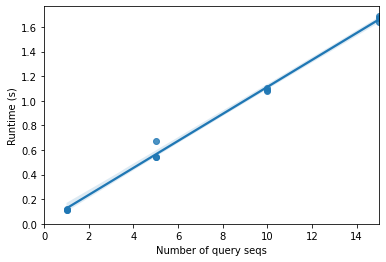

In [17]:
import seaborn as sns
ax = sns.regplot(x="Number of query seqs", y="Runtime (s)", data=local_alignment_search_runtimes)
ax.set_xlim(0)
ax.set_ylim(0)
ax

What we see here is pretty clearly a linear relationship: $runtime \approx constant \times number\ of\ query\ sequences$. This is because as we increase the number of query sequences, we're increasing the number of pairwise alignments that we need to perform. If we have 5 queries and 10 reference sequences, we compute $5 \times 10 = 50$ pairwise alignments. If we have 10 queries and 100 reference sequences, we compute $10 \times 100 = 1000$ pairwise alignments. There are a few practical ways to reduce the runtime of a process like this.

The first seems obvious, and even silly at first: perform fewer alignments. This could be achieved in a few ways. You could reduce the number of query sequences, though this might be something a researcher is resistant to: they have some collection of unknown sequences, and they want to know what they all are. You could alternatively reduce the number of reference sequences, but you might run into the same issues there: we wouldn't want to exclude reference sequences that might provide us with useful information about our query sequences. Finally, we might be able to figure out some ways to perform fewer alignments by not searching all of the query sequences against all of the reference sequences. If we could come up with some procedure to approximate which pairwise alignments were likely to be good (i.e., high scoring) and which were likely to be bad (i.e., low scoring) that is faster than performing the pairwise alignments, we could apply that procedure and only align a pair of sequences when we expect to get a high score. That could potentially allow us to reduce the number of alignments we need to perform, and therefore the runtime of the algorithm.

Another approach to reducing the runtime of this process would be to create a faster implementation of the algorithm (though at some point that won't be possible anymore), use a faster computer, or run the process in parallel on multiple processors. All of these would be ways to reduce the runtime of the search by some factor $f$, where $new\ runtime \approx \frac{runtime}{f}$.

In practice, for a production-scale sequence database search application like BLAST, we'd combine these approaches. In the next section we'll explore ways to reduce the runtime of database searching for a fixed number of query sequences and a fixed number of reference sequences by reducing the number of pairwise alignments that the search function will perform.

## Heuristic algorithms 

As mentioned above, it just takes too long to search individual query sequences against a large database. This problem also isn't going away anytime soon. While computers are getting faster (or cheaper), the size of our sequences collections are getting bigger because sequencing is getting cheaper. In fact, many people think that obtaining DNA sequences is getting cheaper faster than computers are getting cheaper. As our number of query sequences increases because we are able to obtain more for the same amount of money, and the size of our reference databases increases (because we're continuously obtaining more sequence data) this will increasingly become a bigger problem. Figures 1 and 2, respectively, illustrate that these are both real-world issues. Notice that the axes are on a log scale in both cases.

In [18]:
import IPython.display
IPython.display.IFrame(width="600", height="394", src="https://docs.google.com/spreadsheets/d/1vUkUuZsRlLW5U05rXXUn8B2sDYwShkClRMGa8Wiu6bc/pubchart?oid=1844125885&amp;format=interactive")

Figure 1: Genome sequencing costs.

In [19]:
import IPython.display
IPython.display.IFrame(width="763", height="371", src="https://docs.google.com/spreadsheets/d/1vUkUuZsRlLW5U05rXXUn8B2sDYwShkClRMGa8Wiu6bc/pubchart?oid=2103353397&amp;format=interactive")

Figure 2: Size of GenBank.

One way that we can deal with this problem is by recognizing that most of the alignments that are performed in a database search are unlikely to be very good alignments. An algorithm developer could therefore improve runtime by defining a heuristic (or a rule) that is applied to determine which reference sequences are likely to result in good alignments, and only aligning the query against those. For it to be useful, making the decision to align or not (i.e., applying the heuristic) must be *much faster* than actually performing the pairwise alignment. The heuristic also needs to make *good* choices about which reference sequences to align the query against. If the algorithm chooses to not align against a specific reference, that reference is ruled out as a possible result of the database search. A good heuristic for sequence homology searching would therefore be very unlikely to exclude the best alignment(s). When thinking about heuristic algorithms in general, there are some important considerations:

1. How often does the heuristic algorithm fail to get the right answer (in our case, does it make good choices about which reference sequences to align against)?
2. How much faster is the heuristic than the "complete" approach, and is that reduction in runtime enough to justify not being guaranteed to get the best answer?

We'll now look at a few heuristics in the context of these questions.

### Random reference sequence selection 

Our first heuristic will be a [straw man](https://en.wikipedia.org/wiki/Straw_man) that we use as a baseline. We'll select a random $p\%$ of the reference sequences to align our query against. This will clearly result in a large decrease in the number of sequence alignments that we need to perform because we'll go from performing $R_s$ (the reference database size) sequence alignments to $p \times R_s$ sequence alignments for each query sequence $q_i$.

Here's the source code for this. You can see that we're just wrapping our ``local_alignment_search`` function in a function that samples down to $p\%$ of the reference sequences.

In [20]:
import random

def heuristic_local_alignment_search_random(
        queries, reference_db, p, n=5, aligner=local_pairwise_align_ssw):
    k = int(p * len(reference_db))
    database_subset = random.sample(reference_db, k)
    return local_alignment_search(queries, database_subset, n=n, aligner=aligner)

Let's select some new queries and see how the results compare to our known taxonomies.

In [21]:
current_queries = random.sample(queries, k=10)

In [22]:
results = heuristic_local_alignment_search_random(current_queries, reference_db, p=0.10)

for q in current_queries:
    q_id = q.metadata['id']
    print('Closest taxonomies for query %s (in order):' % q_id)
    for e in results['reference taxonomy'][q_id]:
        print(' ', e)
    print()

Closest taxonomies for query 91331 (in order):
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Pseudoalteromonadaceae; g__; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Vibrionaceae; g__Vibrio; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Vibrionaceae; g__Vibrio; s__
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Trabulsiella; s__farmeri
  k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Pseudoalteromonadaceae; g__; s__

Closest taxonomies for query 537310 (in order):
  k__Bacteria; p__Acidobacteria; c__[Chloracidobacteria]; o__RB41; f__Ellin6075; g__; s__
  k__Bacteria; p__Acidobacteria; c__Sva0725; o__Sva0725; f__; g__; s__
  k__Bacteria; p__Cyanobacteria; c__4C0d-2; o__YS2; f__; g__; s__
  k__Bacteria; p__Acidobacteria; c__[Chloracidobacteria]; o__RB41; f__; g__; s__
  k__Bacteria; p__Chlorobi; c__BS

In [23]:
for q in current_queries:
    q_id = q.metadata['id']
    print('Known taxonomy for query %s:\n %s' % (q_id, reference_taxonomy[q_id]))

Known taxonomy for query 91331:
 k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Vibrionaceae; g__Vibrio; s__
Known taxonomy for query 537310:
 k__Bacteria; p__Acidobacteria; c__[Chloracidobacteria]; o__PK29; f__; g__; s__
Known taxonomy for query 267966:
 k__Bacteria; p__Nitrospirae; c__Nitrospira; o__Nitrospirales; f__[Thermodesulfovibrionaceae]; g__BD2-6; s__
Known taxonomy for query 355046:
 k__Bacteria; p__Bacteroidetes; c__[Saprospirae]; o__[Saprospirales]; f__Chitinophagaceae; g__; s__
Known taxonomy for query 4464861:
 k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Pseudonocardiaceae; g__; s__
Known taxonomy for query 4399476:
 k__Bacteria; p__Fibrobacteres; c__TG3; o__TG3-1; f__; g__; s__
Known taxonomy for query 299808:
 k__Bacteria; p__Firmicutes; c__Erysipelotrichi; o__Erysipelotrichales; f__Erysipelotrichaceae; g__; s__
Known taxonomy for query 1127630:
 k__Bacteria; p__Verrucomicrobia; c__Opitutae; o__Opitutales; f__Op

What we need now is a way to know how often we get the "right answer", and how long this heuristic algorithm takes relative to the complete algorithm. We therefore first need to define what the "right answer" is. How about this: if the most common taxonomy assignment resulting from the database search at `taxonomy_levels` levels of taxonomy (i.e., how deep or specific our assignment is) matches the known taxonomy, then our algorithm has achieved the right answer. We can vary `taxonomy_levels` to see how the different heuristics perform at different levels.

Here's what this would look like:

In [24]:
import collections

def evaluate_search(queries, reference_db, reference_taxonomy, search_function, taxonomy_levels, n=5, aligner=local_pairwise_align_ssw):
    start_time = time.time()
    search_results = search_function(current_queries, reference_db, n=n, aligner=aligner)
    stop_time = time.time()
    runtime = stop_time - start_time
    per_query_runtime = runtime/len(queries)
    data = []
    indices = []
    for q in queries:
        q_id = q.metadata['id']
        indices.append(q_id)
        q_known_taxonomy = tuple(reference_taxonomy[q_id].split('; ')[:taxonomy_levels])
        q_observed_taxonomies = collections.Counter()
        for e in search_results['reference taxonomy'][q_id]:
            q_observed_taxonomies[tuple(e.split('; ')[:taxonomy_levels])] += 1
        q_observed_taxonomy = q_observed_taxonomies.most_common()[0][0]
        data.append((q_known_taxonomy, q_observed_taxonomy))
    index = pd.Index(indices, name='Query ID')
    data = pd.DataFrame(data, index=index, columns=['Known taxonomy', 'Observed taxonomy'])
    number_correct = np.sum(data['Known taxonomy'] == data['Observed taxonomy'])
    fraction_correct = number_correct / data.shape[0]
    return per_query_runtime, fraction_correct, data

First let's see how this works for our full database search algorithm. What's the runtime, and how often do we get the correct answer? We'll start with five levels of taxonomy (which corresponds to the family level). **This step will take a couple of minutes to run, because it's doing the full database search.**

In [25]:
taxonomy_levels = 5

In [26]:
runtime, fraction_correct, data = evaluate_search(current_queries, reference_db, reference_taxonomy,
                                                  local_alignment_search, taxonomy_levels=taxonomy_levels)
print('%1.2f seconds per query sequence' % runtime)
print('%1.2f%% correct answers' % (fraction_correct * 100.0))
print('Result details:')
for q_id in data.index:
    print(q_id)
    print(' ', data['Known taxonomy'][q_id])
    print(' ', data['Observed taxonomy'][q_id])
    print()

5.59 seconds per query sequence
80.00% correct answers
Result details:
91331
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')

537310
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')

267966
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')

355046
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')

4464861
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Pseudonocardia

Next let's see how this compares to our random heuristic search algorithm. Try running this a few times, as you might get different answers due to different random selections of the database.

In [27]:
import functools

heuristic_local_alignment_search_random_10 = functools.partial(heuristic_local_alignment_search_random, p=0.10)

runtime, fraction_correct, data = evaluate_search(current_queries, reference_db, reference_taxonomy,
                                                  heuristic_local_alignment_search_random_10, taxonomy_levels=taxonomy_levels)

print('%1.2f seconds per query sequence' % runtime)
print('%1.2f%% correct answers' % (fraction_correct * 100.0))
print('Result details:')
for q_id in data.index:
    print(q_id)
    print(' ', data['Known taxonomy'][q_id])
    print(' ', data['Observed taxonomy'][q_id])
    print()

0.56 seconds per query sequence
30.00% correct answers
Result details:
91331
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Enterobacteriales', 'f__Enterobacteriaceae')

537310
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__RB41', 'f__Ellin6075')

267966
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Micrococcaceae')

355046
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')

4464861
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', '

Again, what's the runtime, and how often do we get the correct answer? Based on comparison to the full search, what do you think: is this a good heuristic?

After performing many trials of the above searches, I get the correct genus-level assignment about half as often with the random reference database heuristic relative to the full database search. Your results might differ from that due to differences in the random selection of query and reference sequences. Try running all the cells in this section a few times.

Go back to the beginning of this section and try running this check based on fewer levels of taxonomy (i.e., decreased taxonomic specificity, such as the phylum) and on more levels of taxonomy (i.e., increased taxonomic specificity, such as the species level). How does that impact how often we get the right answer?

### Composition-based reference sequence collection 

While the random selection of database sequences can vastly reduce the runtime for database searching, we don't get the right answer very often. Let's try some heuristics that are a bit smarter. How about this: if the overall nucleotide composition of a query sequence is very different than the overall nucleotide composition of a reference sequence, it's unlikely that the best alignment will result from that pairwise alignment, so don't align the query to that reference sequence. Given that, how do we define "overall nucleotide composition" in a useful way?

#### GC content 

One metric of sequence composition that we can compute quickly (because remember, this has to be a lot faster than computing the alignment for it to be worth it) is GC content. Let's define a heuristic that only performs a pairwise alignment for the reference sequences that have the most similar GC content to the query sequence. The number of alignments that we'll perform will be defined as ``database_subset_size``.

In [28]:
database_subset_size = 500

In [29]:
def heuristic_local_alignment_search_gc(
        queries, reference_db, database_subset_size, n=5,
        reference_db_gc_contents=None,
        aligner=local_pairwise_align_ssw):
    results = []
    if reference_db_gc_contents is None:
        reference_db_gc_contents = \
         {r.metadata['id'] : r.gc_content() for r in reference_db}
    for q in queries:
        query_gc_content = q.gc_content()
        database_subset = []
        for r in reference_db:
            ref_gc_content = reference_db_gc_contents[r.metadata['id']]
            # find the difference in GC content between the reference and
            # query. we'll sort and select our reference sequences by this
            # value
            database_subset.append((abs(ref_gc_content - query_gc_content), r))
        database_subset.sort(key=lambda x: x[0])
        database_subset = [e[1] for e in database_subset[:database_subset_size]]
        results.append(local_alignment_search(
            [q], database_subset, n=n, aligner=aligner))
    return pd.concat(results)

If we run our queries again, how often do we get the right answer? How much did we reduce runtime? Do you think this is a better or worse heuristic than what we implemented above?

In [30]:
heuristic_local_alignment_search_gc_2 = functools.partial(heuristic_local_alignment_search_gc, database_subset_size=database_subset_size)

runtime, fraction_correct, data = evaluate_search(current_queries, reference_db, reference_taxonomy,
                                                  heuristic_local_alignment_search_gc_2, taxonomy_levels=taxonomy_levels)

print('%1.2f seconds per query sequence' % runtime)
print('%1.2f%% correct answers' % (fraction_correct * 100.0))
print('Result details:')
for q_id in data.index:
    print(q_id)
    print(' ', data['Known taxonomy'][q_id])
    print(' ', data['Observed taxonomy'][q_id])
    print()

0.61 seconds per query sequence
20.00% correct answers
Result details:
91331
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Enterobacteriales', 'f__Enterobacteriaceae')

537310
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')
  ('k__Bacteria', 'p__Chlorobi', 'c__SJA-28', 'o__', 'f__')

267966
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')

355046
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')
  ('k__Bacteria', 'p__Gemmatimonadetes', 'c__Gemmatimonadetes', 'o__Ellin5290', 'f__')

4464861
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Pseudonocardiaceae')
  ('k__Bacteria', 'p

Try increasing and decreasing the number of sequences we'll align by increasing or decreasing ``database_subset_size``. How does this impact the runtime and fraction of time that we get the correct answer?

(kmer)=
#### kmer content 

Another metric of sequence composition is *kmer composition*. A kmer is simply a word (or list of adjacent characters) of length *k* found within a sequence. Here are the kmer frequencies in a short DNA sequence. The ``overlap=True`` parameter here means that our kmers can overlap one another.

In [31]:
import skbio

skbio.DNA('ACCGTGACCAGTTACCAGTTTGACCAA').kmer_frequencies(k=5, overlap=True)

{'ACCGT': 1,
 'CCGTG': 1,
 'CGTGA': 1,
 'GTGAC': 1,
 'TGACC': 2,
 'GACCA': 2,
 'ACCAG': 2,
 'CCAGT': 2,
 'CAGTT': 2,
 'AGTTA': 1,
 'GTTAC': 1,
 'TTACC': 1,
 'TACCA': 1,
 'AGTTT': 1,
 'GTTTG': 1,
 'TTTGA': 1,
 'TTGAC': 1,
 'ACCAA': 1}

In our next heuristic, we'll only align our query to the reference sequences with the largest fraction of the kmers that are observed in the query sequence are also present in the reference sequence. This makes a lot of sense to use as an alignment heuristic: we're only aligning sequences when it looks like they'll have multiple length-``k`` stretches of nucleotides that are not interrupted by substitutions or insertion/deletion mutations.

In our next heuristic, we'll only align our query to the reference sequences with the largest fraction of the kmers that are observed in the query sequence. This makes a lot of sense to use as an alignment heuristic: we're only aligning sequences when it looks like they'll have multiple length-``k`` stretches of nucleotides that are not interrupted by substitutions or insertion/deletion mutations.


Here's the source code:

In [32]:
## TODO: Update this to be Jaccard index (or describe it that way, if it already is)
def fraction_shared_kmers(kmer_freqs1, kmer_freqs2):
    """Compute the fraction of kmers in kmer_freqs1 that are also in kmer_freqs2
    Parameters
    ----------
    kmer_freqs1, kmer_freqs2
    Returns
    -------
    float
    Raises
    ------
    ValueError
        If k < 1.
    Notes
    -----
    k-mer counts are not incorporated in this distance metric.
    """
    sequence1_kmers = set(kmer_freqs1)
    num_sequence1_kmers = len(sequence1_kmers)
    sequence2_kmers = set(kmer_freqs2)
    shared_kmers = sequence1_kmers & sequence2_kmers
    return len(shared_kmers) / num_sequence1_kmers

def heuristic_local_alignment_search_kmers(
        queries, reference_db, database_subset_size, k, n=5,
        reference_db_kmer_frequencies=None,
        aligner=local_pairwise_align_ssw):
    results = []
    if reference_db_kmer_frequencies is None:
        reference_db_kmer_frequencies = \
         {r.metadata['id'] : r.kmer_frequencies(k=k, overlap=True) for r in reference_db}
    for q in queries:
        query_kmer_frequency = q.kmer_frequencies(k=k, overlap=True)
        database_subset = []
        for r in reference_db:
            ref_kmer_frequency = reference_db_kmer_frequencies[r.metadata['id']]
            s = fraction_shared_kmers(query_kmer_frequency, ref_kmer_frequency)
            database_subset.append((s, r))
        database_subset.sort(key=lambda x: x[0], reverse=True)
        database_subset = [e[1] for e in database_subset[:database_subset_size]]
        results.append(local_alignment_search(
            [q], database_subset, n=n, aligner=aligner))
    return pd.concat(results)

In [33]:
k = 7

Let's apply this and see how it does. How does the runtime and fraction of correct assignments compare to our GC content-based search and our full database search?

In [34]:
heuristic_local_alignment_search_kmers_50 = \
functools.partial(heuristic_local_alignment_search_kmers, k=k, database_subset_size=database_subset_size)

runtime, fraction_correct, data = evaluate_search(current_queries, reference_db, reference_taxonomy,
                                                  heuristic_local_alignment_search_kmers_50,
                                                  taxonomy_levels=taxonomy_levels)

print('%1.2f seconds per query sequence' % runtime)
print('%1.2f%% correct answers' % (fraction_correct * 100.0))
print('Result details:')
for q_id in data.index:
    print(q_id)
    print(' ', data['Known taxonomy'][q_id])
    print(' ', data['Observed taxonomy'][q_id])
    print()

6.54 seconds per query sequence
80.00% correct answers
Result details:
91331
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')

537310
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')

267966
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')

355046
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')

4464861
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Pseudonocardia

#### Further optimizing composition-based approaches by pre-computing reference database information 

One important feature of composition-based approaches is that, because the reference database doesn't change very often, we can pre-compute features of the reference sequences and re-use them. This can help us to vastly decrease the runtime of our heuristic searches. For example, the computation of all of the reference database kmer frequencies is a lot of work. If we can compute that outside of our database search, we can avoid doing that step for every database search, and therefore remove that computationally expensive (i.e., slow) step of the process.

Here we'll compute all of the reference database kmer frequencies. Notice that this step takes about a minute to complete. This is a minute of compute time that we can save on every database search!

In [35]:
reference_db_kmer_frequencies = {r.metadata['id']: r.kmer_frequencies(k=k, overlap=True) for r in reference_db}

We'll now pass our pre-computed kmer frequencies into our search function. How does the runtime and accuracy of this search compare to the searches above? This last database search that we've implemented here is very similar to how BLAST works.

In [36]:
heuristic_local_alignment_search_kmers_50 = \
 functools.partial(heuristic_local_alignment_search_kmers, reference_db_kmer_frequencies=reference_db_kmer_frequencies,
                   k=k, database_subset_size=database_subset_size)

runtime, fraction_correct, data = evaluate_search(current_queries, reference_db, reference_taxonomy,
                                                  heuristic_local_alignment_search_kmers_50,
                                                  taxonomy_levels=taxonomy_levels)

print('%1.2f seconds per query sequence' % runtime)
print('%1.2f%% correct answers' % (fraction_correct * 100.0))
print('Result details:')
for q_id in data.index:
    print(q_id)
    print(' ', data['Known taxonomy'][q_id])
    print(' ', data['Observed taxonomy'][q_id])
    print()

0.94 seconds per query sequence
80.00% correct answers
Result details:
91331
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')
  ('k__Bacteria', 'p__Proteobacteria', 'c__Gammaproteobacteria', 'o__Vibrionales', 'f__Vibrionaceae')

537310
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')
  ('k__Bacteria', 'p__Acidobacteria', 'c__[Chloracidobacteria]', 'o__PK29', 'f__')

267966
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')
  ('k__Bacteria', 'p__Nitrospirae', 'c__Nitrospira', 'o__Nitrospirales', 'f__[Thermodesulfovibrionaceae]')

355046
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')
  ('k__Bacteria', 'p__Bacteroidetes', 'c__[Saprospirae]', 'o__[Saprospirales]', 'f__Chitinophagaceae')

4464861
  ('k__Bacteria', 'p__Actinobacteria', 'c__Actinobacteria', 'o__Actinomycetales', 'f__Pseudonocardia

## Determining the statistical significance of a pairwise alignment 

One thing you may have noticed is that the score you get back for a pairwise alignment is hard to interpret. It's dependent on the query and reference sequence lengths (and possibly their composition, depending on your substitution matrix). So an important question is how to determine *how good* a given pairwise alignment is. Here we'll learn about a statistical approach for answering that.

### Metrics of alignment quality 

In the examples above, we compared features such as how long the alignment is (relevant for local but not global alignment), the pairwise similarity between the aligned query and reference, and the score. If you've used a system like BLAST, you'll know that there are other values that are often reported about an alignment, like the number of substitutions, or the number of insertion/deletion (or gap) positions. None of these metrics are useful on their own. Let's look at an example to see why.

Imagine we're aligning these two sequences:

```
GAAGCAGCAC
GAACAGAAC
```

If we tell our search algorithm that we're interested in the alignment with the fewest number of substitutions, the following alignment would get us zero substitutions, but there are a lot of bases that look homologous which are not aligned.

```
GAAGCAGCAC-----
GAA------CAGAAC
```

On the other hand, if we want to find the alignment with the fewest number of gaps, this one would get us that result, but we now have a lot of substitution events, and some regions that clearly look misaligned (such as the ``CAG`` sequence in the middle of both).

```
GAAGCAGCAC
GAACAGA-AC
```

The alignment score that has been reported by our pairwise aligners helps us to balance these different features, and we can adjust the scoring scheme to weight things differently (e.g., so that gaps are penalized more or less than certain substitutions). The problem is that the scores are hard to interpret, particularly when we have only one or a few of them.

### False positives, false negatives, p-values, and alpha  

Remember that an alignment of a pair of sequences represents a hypothesis about homology between those sequences. One way that we think about determining if an alignment is good or not is to ask: *what fraction of the time would I obtain a score at least this good if my sequences are not homologous?* This fraction is usually referred to as our *p-value*, and this is computed in many different ways. If our p-value is high (e.g., 25%), then our alignment is probably not very good since it means that many non-homologous pairs of sequences would achieve a score at least that high. If our p-value is low (say 0.001%), then our alignment is probably good since scores that high are achieved only infrequently.

Our threshold for defining what we consider to be a high versus low p-value is dependent on how often we're willing to be wrong. We would set this value, which is usually referred to as $\alpha$, to some fraction, and if our p-value is less than $\alpha$, we say that the alignment is statistically significant. If our p-value is greater than $\alpha$, we say that our alignment is not statistically significant.

There are a couple of ways that we could be wrong when we do sequence homology searching, and we need to consider these when we determine what value we want to define as $\alpha$. First, we could say a pair of sequences are homologous when they're not, which would be a *false positive* or a *type 1 error*. Or, we could say that a pair of sequences are not homologous when they are, which would be a *false negative*, or a *type 2 error*.

If incurring a false positive about 5% of the time is acceptable (i.e., you're ok with calling a pair of sequences homologous when they actually are not about one in twenty times) then you'd set your $\alpha$ to 0.05. Setting $\alpha$ to a value this high likely means that the method will err on the side of false positives, and only infrequently will it say that a pair of sequences are not homologous when they actually are (i.e., achieve a false negative). If $\alpha$ were set to be very low on the other hand (say, $1 \times 10^{-50}$), then you will err on the side of false negatives. Only infrequently will you say that a pair of non-homologous sequences are homologous, but you might call many pairs of homologous sequences non-homologous. You should think of $\alpha$ as a dial. If you turn the dial toward higher values, you'll increase your false positive rate and decrease your false negative rate. If you turn the dial toward lower values, you'll decrease your false positive rate and increase your false negative rate.

There is not a hard-and-fast rule for whether false positives or false negatives are better, which makes choosing $\alpha$ hard. It's application specific, so you need to understand the biological question your asking when making this decision, and the ramifications of false positives versus false negatives. In general, when might you prefer to have false positives? When might you prefer to have false negatives?

### Interpreting alignment scores in context 

In this section, we are going to learn about how to interpret alignment scores by empirically determining if a pairwise alignment that we obtain is better than we would expect if the pair of sequences we're working with were definitely not homologous. For a given pair of sequences that we want to align, we're first going to align them and compute the score of the alignment. We're then going to align many pairs of sequences that are similar to the query and reference, but that we know are not homologous. We'll do this by shuffling or randomizing the order of the bases in the query sequences, and performing another pairwise alignment.

First, we'll define a function that can generate random sequences for us. This will take a scikit-bio sequence object (either ``skbio.DNA``, ``skbio.RNA``, or ``skbio.Protein``) and a length, and it will randomly generate a sequence of that type and length for us.

In [37]:
import random
def random_sequence(moltype, length):
    result = []
    alphabet = list(moltype.nondegenerate_chars)
    for e in range(length):
        result.append(random.choice(alphabet))
    return moltype(''.join(result))

We can now run this a few times to generate some random sequences:

In [38]:
random_sequence(skbio.DNA, 50)

DNA
--------------------------------------------------------
Stats:
    length: 50
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 48.00%
--------------------------------------------------------
0 GAAAGGACTC AATAGCTGCA GGCATATTGT ACGGCTTACG TCCCAGAAAC

In [39]:
random_sequence(skbio.DNA, 50)

DNA
--------------------------------------------------------
Stats:
    length: 50
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 46.00%
--------------------------------------------------------
0 TGTCTCGTAT TAACTTCCCG GGTGAGAAAA AGCCCCTTAT CTGCTTCAAC

Next, we need a function that will shuffle the characters in a sequence, and give us a new sequence back. We'll use this to generate a sequence that is similar (in length and composition) to our input sequence, but which we know is not homologous. We'll use Pythons `random.shuffle` function, which randomly re-orders the order of the elements in a sequence, but keeps the composition and length of the sequence the same.

In [40]:
def shuffle_sequence(sequence):
    # generate a list of the position indices (numbers) in sequence
    randomized_order = list(range(len(sequence)))
    # randomly rearrange the order of that list
    random.shuffle(randomized_order)
    # return a new sequence, where the positions are shuffled
    return sequence[randomized_order]

Now we can define a random sequence and shuffle it. Notice how the sequences are different (in their order), but their compositions (e.g., length and GC content) are the same. Shuffling will change the order of the bases, but it won't change the frequency at which each base is present - it's exactly analogous to shuffling a deck of cards.

In [41]:
seq = random_sequence(skbio.DNA, 50)
seq

DNA
--------------------------------------------------------
Stats:
    length: 50
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 48.00%
--------------------------------------------------------
0 TGTTACAGAC GCTCAAGAAG CTCCTTTGCC GTTGGTAGAC ATCATAACCG

In [42]:
shuffle_sequence(seq)

DNA
--------------------------------------------------------
Stats:
    length: 50
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 48.00%
--------------------------------------------------------
0 GCACATCACC ATTCTAGGGG ATGCCTTAAG CCATTGTTGA AAGCTTGCCA

Let's generate a random query sequence and align it against itself to see what that score would be.

In [43]:
query_seq = random_sequence(skbio.DNA, 50)
_, actual_score, _ = local_pairwise_align_ssw(query_seq, query_seq)
print("Score: %1.2f" % actual_score)

Score: 100.00


Next let's generate 99 random variants of that sequence with ``shuffle_sequence`` and compute the pairwise alignment for each of those variants against the query sequence. We'll then look at the distribution of those scores.

In [44]:
def generate_random_score_distribution(sequence1,
                                       sequence2,
                                       n=99,
                                       aligner=local_pairwise_align_ssw):
    scores = []
    # iterate n times
    for i in range(n):
        # generate a randomized version of the first sequence
        random_sequence = shuffle_sequence(sequence1)
        # align that randomized sequence against the second sequence
        # and save its score
        _, score, _ = aligner(random_sequence, sequence2)
        scores.append(score)
    # return the n randomized alignment scores
    return scores

In [45]:
random_scores = generate_random_score_distribution(query_seq, query_seq, 99)
print(random_scores)

[8, 12, 10, 11, 10, 8, 10, 10, 13, 12, 8, 12, 13, 12, 14, 10, 10, 9, 8, 17, 11, 10, 12, 12, 10, 10, 11, 8, 10, 18, 10, 12, 11, 10, 14, 17, 12, 12, 12, 14, 13, 11, 11, 10, 11, 12, 10, 10, 10, 10, 13, 10, 14, 17, 10, 11, 9, 13, 12, 10, 10, 12, 17, 10, 12, 12, 11, 14, 10, 12, 10, 10, 12, 11, 14, 10, 14, 11, 10, 10, 10, 14, 15, 10, 12, 11, 10, 10, 10, 16, 13, 10, 12, 13, 8, 9, 10, 9, 10]


How does the actual score of aligning the sequence to itself compare to the score of aligning it to many similar but non-homologous sequences? Let's plot these to get a better idea.

In [46]:
import seaborn as sns

def plot_score_distribution(actual_score, random_scores):
    ax = sns.distplot(random_scores, kde=False, label="Random scores", color="b")
    ax.plot([actual_score, actual_score], ax.get_ylim(), '--', label="Actual score")
    # set the range of the x axis to be zero through 110% of the actual score
    ax.set_xlim(0, actual_score + actual_score * 0.1)
    ax.legend(loc=9, fontsize='large')
    return ax

/usr/share/miniconda/envs/q2book/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


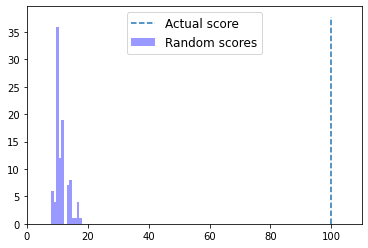

In [47]:
plot_score_distribution(actual_score, random_scores)

What does this tell us about our alignment score and therefore about our alignment? Is it good or bad?

We finally have information that we can use to evaluate an alignment score, and therefore to evaluate the quality of an alignment. Let's use this information to quantify the quality of the alignment by computing a p-value. As we described above, this is simply the probability that we would obtain an alignment score at least this good if the sequences being aligned are not homologous. Since we have a lot of scores now from sequences that are similar but not homologous, if we just count how many are at least as high as our actual score and divide by the number of scores we compute, that is an empirical (data-driven) way of determining our p-value.

To determine if our alignment is statistically significant, we need to define $\alpha$ before computing the p-value so the p-value does not impact our choice of $\alpha$. Let's define $\alpha$ as 0.05. This choice means if we obtain a p-value less than 0.05 we will consider the alignment statistically significant and accept the hypothesis that the sequences are homologous.

Here's what all of this looks like:

In [48]:
def generate_random_score_distribution(sequence1,
                                       sequence2,
                                       n=99,
                                       aligner=local_pairwise_align_ssw):
    scores = []
    # iterate n times
    for i in range(n):
        # generate a randomized version of the first sequence
        random_sequence = shuffle_sequence(sequence1)
        # align that randomized sequence against the second sequence
        # and save its score
        _, score, _ = aligner(random_sequence, sequence2)
        scores.append(score)
    # return the n randomized alignment scores
    return scores

def fraction_better_or_equivalent_alignments(sequence1,
                                             sequence2,
                                             n = 99,
                                             aligner=local_pairwise_align_ssw):
    # align sequence1 and sequence2 and store the score of the alignment
    _, actual_score, _ = aligner(sequence1, sequence2)
    # compute the distribution of randomized scores
    random_scores = generate_random_score_distribution(sequence1,
                                                       sequence2,
                                                       n,
                                                       aligner=aligner)

    # count the number of random scores that are at least as good as our
    # actual score
    count_better = 0
    for s in random_scores:
        if s >= actual_score:
            count_better += 1
    # return the number of times we observe a score at least as good as the
    # random score divided by the number of scores we computed. we add one
    # to the numerator and denominator to account for our actual_score
    return (count_better + 1) / (n + 1)

In [49]:
print("Fraction of alignment scores at least as good as the alignment score: %r" %
      fraction_better_or_equivalent_alignments(query_seq, query_seq, 99))

Fraction of alignment scores at least as good as the alignment score: 0.01


The fraction that we get back here is ``0.01``, which is lower than $\alpha$, so we would accept the hypothesis that our sequences are homologous.

A few notes on these empirically defined p-values. First, here's what the formula for computing this looks like:

$p\ value = \frac{number\ of\ computed\ aligned\ scores\ greater\ than\ or\ equal\ to\ the\ actual\ alignment\ score}{number\ of\ alignment\ scores\ computed}$

The numerator and the denominator both include the actual alignment score, so the lowest p-value that can be achieved is $\frac{1}{99 + 1}$, where the $1$ in the numerator corresponds to our actual alignment score (which is of course equal to itself), where the $99$ in the denominator is the number of permutations, and the $1$ in the denominator is a constant which corresponds the computation of the actual score. If we increase the number of permutations, say to 999, we could achieve greater precision (more significant digits) in our p-value.

In [50]:
print("Fraction of alignment scores at least as good as the alignment score: %r" %
      fraction_better_or_equivalent_alignments(query_seq, query_seq, 999))

Fraction of alignment scores at least as good as the alignment score: 0.001


When we achieve the lowest possible value for a given test, as is the case here, we report the p-value as being less than that value, since we've yet to observe a random alignment score at least that high. For example, here we would report something like:

*The alignment of our query and reference sequence was statistically significant, as determined by comparing our actual alignment score to random variants ($p < 0.001$).*

Let's now try this for some harder cases, where the query and subject sequences are not identical. First, let's generate a longer subject sequence at random. Then, we'll create a random query sequence and compare it. Since we're doing this in two random steps, we know that these sequences are not homologous. Does the resulting p-value reflect that?

In [51]:
sequence1 = random_sequence(skbio.DNA, 250)
sequence1

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 51.60%
---------------------------------------------------------------------
0   AGAACCCTAT AAGGCCGGGG CCGTAACAAC AGGTCTGGTG ACGAACAAAG AGCGCGAGCG
60  GATTTCCGTA CATCCCTCAG AGACCAGGAC GAACTACGTT AAGAGGCATC TGCACCCGTA
120 GACCAGCCCG AGTTTTACCT TAAAAGATGG GCTACAAACT GCTGTAGTCA AGATCTGGAG
180 TAGGCCAGTG CCCTTTCGGC TTTTTAGGAG TGGAAGACCT ATTGTCATGT GAAGTTGCGT
240 CCATCGTGTC

In [52]:
sequence2 = random_sequence(skbio.DNA, 250)
sequence2

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 45.60%
---------------------------------------------------------------------
0   AGACAAGTAA CCTGATTGTA CTCATAAATG GGGATAGCTC ATCCGACCGG GCTAGCATTA
60  ATGAAAACAA CTCTAAAGAT GCTGATTCCC GTGAGGAGCG TGCTAATGAT GTTCACACGC
120 ATTAATTATC AGCTACGAAG TACAGTAAGC TGCGGGAGTA ATTAGCTGCC CCTGCTTACA
180 CGTTGCGGAG CTCATCCAAA CAATAGTTCG ACGTCATCTT TTGGAGCGAG TTGCAAAGCA
240 TCATTAGGCG

In [53]:
print("Fraction of alignment scores at least as good as the alignment score: %r" %
      fraction_better_or_equivalent_alignments(sequence1,sequence2))

Fraction of alignment scores at least as good as the alignment score: 0.93


We've now looked at two extremes: where sequences are obviously homologous (because they were the same), and where sequences are obviously not homologous (because they were both independently randomly generated). Next, we'll explore the region between these, where this gets interesting. We'll now create a partially randomized sequence to create a pair of sequences where the homology is more obscure. We'll do this again using the Python ``random`` module, but this time we'll introduce mutations only at some positions to create a pair of sequences that are approximately ``percent_id`` identical.

Let's define a function to do this, and then compute a sequence that is 95% identical to our ``sequence1``.

In [54]:
def partially_randomize_sequence(percent_id, sequence):
    result = []
    for c in sequence:
        if random.random() < percent_id:
            result.append(str(c))
        else:
            # choose a base at random that is not the current base
            # i.e., simulate a substitution event
            result.append(choice([r for r in sequence.nondegenerate_chars if r != c]))
    return sequence.__class__(''.join(result))

In [55]:
sequence1_95 = partially_randomize_sequence(0.95, sequence1)

In [56]:
sequence1

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 51.60%
---------------------------------------------------------------------
0   AGAACCCTAT AAGGCCGGGG CCGTAACAAC AGGTCTGGTG ACGAACAAAG AGCGCGAGCG
60  GATTTCCGTA CATCCCTCAG AGACCAGGAC GAACTACGTT AAGAGGCATC TGCACCCGTA
120 GACCAGCCCG AGTTTTACCT TAAAAGATGG GCTACAAACT GCTGTAGTCA AGATCTGGAG
180 TAGGCCAGTG CCCTTTCGGC TTTTTAGGAG TGGAAGACCT ATTGTCATGT GAAGTTGCGT
240 CCATCGTGTC

In [57]:
sequence1_95

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 52.00%
---------------------------------------------------------------------
0   AGAACCCTAT AAGGCCCGGG CCGTAACAAC AGCTCTGGTG ACGAACAAAG AGCGCGAGCG
60  GATTTCCATA CAGCCCTCAG AGACCAGGAC GAACAACGTT AAGAGGCATC TGCACCCGTA
120 GACCAGCTCG AGCGTTACCT TAAAAGATGG GCTACAAGCT GCGGTAGTCA AGATCTGGAG
180 TAGGCCAGTG CCCTTTCGGC TTTTTAGGAG TGGAAGACAT ATTGTCATCT GAAGTTGCGT
240 CTATCGTGTC

Notice how these sequences are almost identical, but have some differences. Let's apply our approach to determine if it would identify these sequences as being homologous based on $\alpha = 0.05$.

In [58]:
print("Fraction of alignment scores at least as good as the alignment score: %r" %
      fraction_better_or_equivalent_alignments(sequence1, sequence1_95))

Fraction of alignment scores at least as good as the alignment score: 0.01


You likely got a significant p-value there, telling you that the sequences are homologous.

Now let's simulate much more distantly related sequences by introducing substitutions at many more sites.

In [59]:
sequence1_25 = partially_randomize_sequence(0.25, sequence1)

In [60]:
sequence1

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 51.60%
---------------------------------------------------------------------
0   AGAACCCTAT AAGGCCGGGG CCGTAACAAC AGGTCTGGTG ACGAACAAAG AGCGCGAGCG
60  GATTTCCGTA CATCCCTCAG AGACCAGGAC GAACTACGTT AAGAGGCATC TGCACCCGTA
120 GACCAGCCCG AGTTTTACCT TAAAAGATGG GCTACAAACT GCTGTAGTCA AGATCTGGAG
180 TAGGCCAGTG CCCTTTCGGC TTTTTAGGAG TGGAAGACCT ATTGTCATGT GAAGTTGCGT
240 CCATCGTGTC

In [61]:
sequence1_25

DNA
---------------------------------------------------------------------
Stats:
    length: 250
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 50.00%
---------------------------------------------------------------------
0   CTTCCCCCAG AAGTGTGACC CACTGTGTAT CGCGCACTGA TCGTGAGTGG ATAACGACCT
60  TATACTCCAG AACTCCTCCG AGCGAAGTCA CAATCACGAA AACACAAATC CGCAAGGGCA
120 CCGTAGGACG ATTTTATATT AATAAGGTTT TTGACCAAGT GCTTTAGGGT ATGTGCGTCA
180 GCGGACTAGA CACCCTAGGC TTTGGAGAAG CGATTGATTC CAGCCCACGC GGGTCTTGGC
240 GCAAGATATG

In [62]:
print("Fraction of alignment scores at least as good as the alignment score: %r" %
      fraction_better_or_equivalent_alignments(sequence1, sequence1_25))

Fraction of alignment scores at least as good as the alignment score: 1.0


### Exploring the limit of detection of sequence homology searches 

In the example above, we know that our input sequences are "homologous" because `sequence1_25` and `sequence1_95` are both derived from `sequence1`. Our method detected that homology for `sequence1_95`, when we simulated very closely related sequences, but not for ``sequence1_25``, when we simulated much more distantly related sequences. This gives us an idea of the limit of detection of this method, and is a real-world problem that biologists face: as sequences are more divergent from one another, detecting homology becomes increasingly difficult.

Lets run a simulation to gain some more insight into the limit of detection of this method. We'll run this approach for pairs of sequences where we vary the ``percent_id`` parameter, and identify when our approach stops identifying sequence pairs as being homologous. This is important to know as a bioinformatician, because it tells us around what pairwise similarity we will no longer be able to identify homology using this approach.

In [63]:
# First, let's define the range of percent identities that we'll test
percent_ids = np.arange(0.0, 1.0, 0.05)
# Then, we'll define the number of random sequences we'll test at each percent identity
num_trials = 20
# Then, we'll define the sequence length that we want to work with, and num_trials random sequences
sequence_length = 150
random_sequences = [random_sequence(skbio.DNA, sequence_length) for i in range(num_trials)]

results = []

for percent_id in percent_ids:
    # at each percent_id, we'll track the p-values for each trial (random sequence)
    p_values = []
    for sequence in random_sequences:
        # partially randomize the sequence, compute its p-value, and record that p-value
        sequence_at_percent_id = partially_randomize_sequence(percent_id, sequence)
        p = fraction_better_or_equivalent_alignments(sequence, sequence_at_percent_id)
        p_values.append(p)
    results.append((percent_id, np.median(p_values), np.mean(p_values)))
pd.DataFrame(results, columns=["Percent id between query and subject",
                               "Median p-value", "Mean p-value"])

,Percent id between query and subject,Median p-value,Mean p-value
0,0.00,0.510,0.5605
1,0.05,0.490,0.5270
2,0.10,0.500,0.5335
3,0.15,0.750,0.6005
4,0.20,0.365,0.4070
5,0.25,0.550,0.5140
6,0.30,0.160,0.2585
7,0.35,0.245,0.2935
8,0.40,0.010,0.1360
9,0.45,0.010,0.0380


What does this simulation tell us about our limit of detection for homology (i.e., how similar must a pair of sequences be for us to reliably be able to identify homology between them)? Is this higher or lower than you expected?

With respect to our simulation, I took a few shortcuts here to keep the runtime low. What are some things that could be improved to make this simulation more robust, if we weren't as concerned about runtime?